In [1]:
!wget 'https://github.com/monasolgi/GPN_Graph-Few-shot/blob/master/few_shot_data/Amazon_electronics_network.txt?raw=true'
!wget 'https://github.com/monasolgi/GPN_Graph-Few-shot/blob/master/few_shot_data/Amazon_eletronics_test.mat?raw=true'
!wget 'https://github.com/monasolgi/GPN_Graph-Few-shot/blob/master/few_shot_data/Amazon_eletronics_train.mat?raw=true'

--2021-06-23 15:11:26--  https://github.com/monasolgi/GPN_Graph-Few-shot/blob/master/few_shot_data/Amazon_electronics_network.txt?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/monasolgi/GPN_Graph-Few-shot/raw/master/few_shot_data/Amazon_electronics_network.txt [following]
--2021-06-23 15:11:27--  https://github.com/monasolgi/GPN_Graph-Few-shot/raw/master/few_shot_data/Amazon_electronics_network.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/monasolgi/GPN_Graph-Few-shot/master/few_shot_data/Amazon_electronics_network.txt [following]
--2021-06-23 15:11:27--  https://raw.githubusercontent.com/monasolgi/GPN_Graph-Few-shot/master/few_shot_data/Amazon_electronics_network.txt
Resolving raw.githubusercontent.com (raw.githubusercontent

In [2]:
import numpy as np
import scipy.sparse as sp
import torch
import scipy.io as sio
import random
from sklearn import preprocessing
from sklearn.metrics import f1_score

valid_num_dic = {'Amazon_clothing': 17, 'Amazon_eletronics': 36, 'dblp': 27}

def load_data(dataset_source):
    n1s = []
    n2s = []
    for line in open("/content/Amazon_electronics_network.txt?raw=true"):
        n1, n2 = line.strip().split('\t')
        n1s.append(int(n1))
        n2s.append(int(n2))

    num_nodes = max(max(n1s),max(n2s)) + 1
    adj = sp.coo_matrix((np.ones(len(n1s)), (n1s, n2s)),
                                 shape=(num_nodes, num_nodes))


    data_train = sio.loadmat("/content/Amazon_eletronics_train.mat?raw=true")
    train_class = list(set(data_train["Label"].reshape((1,len(data_train["Label"])))[0]))
    

    data_test = sio.loadmat("/content/Amazon_eletronics_test.mat?raw=true")
    class_list_test = list(set(data_test["Label"].reshape((1,len(data_test["Label"])))[0]))


    labels = np.zeros((num_nodes,1))
    labels[data_train['Index']] = data_train["Label"]
    labels[data_test['Index']] = data_test["Label"]

    features = np.zeros((num_nodes,data_train["Attributes"].shape[1]))
    features[data_train['Index']] = data_train["Attributes"].toarray()
    features[data_test['Index']] = data_test["Attributes"].toarray()

    class_list = []
    for cla in labels:
        if cla[0] not in class_list:
            class_list.append(cla[0])  # unsorted

    id_by_class = {}
    for i in class_list:
        id_by_class[i] = []
    for id, cla in enumerate(labels):
        id_by_class[cla[0]].append(id)

    lb = preprocessing.LabelBinarizer()
    labels = lb.fit_transform(labels)

    degree = np.sum(adj, axis=1)
    degree = torch.FloatTensor(degree)

    adj = normalize_adj(adj + sp.eye(adj.shape[0]))
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(np.where(labels)[1])

    adj = sparse_mx_to_torch_sparse_tensor(adj)
    
    class_list_valid = random.sample(train_class, valid_num_dic[dataset_source])

    class_list_train = list(set(train_class).difference(set(class_list_valid)))

    return adj, features, labels, degree, class_list_train, class_list_valid, class_list_test, id_by_class 



def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def f1(output, labels):
    preds = output.max(1)[1].type_as(labels)
    f1 = f1_score(labels, preds, average='weighted')
    return f1


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)



def task_generator(id_by_class, class_list, n_way, k_shot, m_query):

    # sample class indices
    class_selected = random.sample(class_list, n_way)
    id_support = []
    id_query = []
    for cla in class_selected:
        temp = random.sample(id_by_class[cla], k_shot + m_query)
        id_support.extend(temp[:k_shot])
        id_query.extend(temp[k_shot:])

    return np.array(id_support), np.array(id_query), class_selected



def euclidean_dist(x, y):
    # x: N x D query
    # y: M x D prototype
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)  # N x M



In [3]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import torch.nn as nn
import torch.nn.functional as F


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class GPN_Encoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GPN_Encoder, self).__init__()

        self.gc1 = GraphConvolution(nfeat, 2 * nhid)
        self.gc2 = GraphConvolution(2 * nhid, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)

        return x

class GPN_Valuator(nn.Module):

    def __init__(self, nfeat, nhid, dropout):
        super(GPN_Valuator, self).__init__()
        
        self.gc1 = GraphConvolution(nfeat, 2 * nhid)
        self.gc2 = GraphConvolution(2 * nhid, nhid)
        self.fc3 = nn.Linear(nhid, 1)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = self.fc3(x)

        return x


-------Episode 10-------
Meta-Train_Accuracy: 0.500909090909091
Meta-loss_train: 1.380388617515564
Meta-valid_Accuracy: 0.6831999999999999, Meta-valid_F1: 0.6769326929700665
meta_valid_loss: 0.9954483509063721
Meta-Test_Accuracy: 0.538, Meta-Test_F1: 0.5239818206936977
meta_test_loss: 1.333845615386963
-------Episode 20-------
Meta-Train_Accuracy: 0.5385714285714285
Meta-loss_train: 3.217928647994995
Meta-valid_Accuracy: 0.6978, Meta-valid_F1: 0.6928043563375682
meta_valid_loss: 0.9339289665222168
Meta-Test_Accuracy: 0.5546, Meta-Test_F1: 0.5424012595718267
meta_test_loss: 1.2780945301055908
-------Episode 30-------
Meta-Train_Accuracy: 0.5574193548387097
Meta-loss_train: 2.681878089904785
Meta-valid_Accuracy: 0.715, Meta-valid_F1: 0.7120026097096297
meta_valid_loss: 0.9300994277000427
Meta-Test_Accuracy: 0.578, Meta-Test_F1: 0.5672838551241256
meta_test_loss: 1.230103850364685
-------Episode 40-------
Meta-Train_Accuracy: 0.5695121951219512
Meta-loss_train: 2.306316375732422
Meta-vali

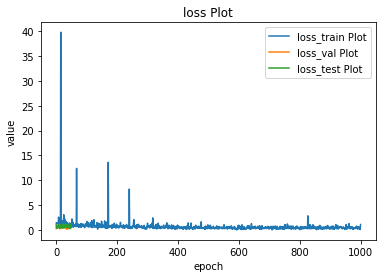

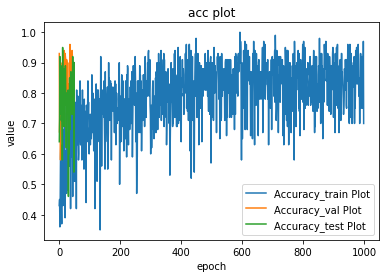

Total time elapsed: 15091.4750s


In [5]:

from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--use_cuda', action='store_true', help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=1234, help='Random seed.')
parser.add_argument('--episodes', type=int, default=1000,
                    help='Number of episodes to train.')
parser.add_argument('--lr', type=float, default=0.005,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--way', type=int, default=5, help='way.')
parser.add_argument('--shot', type=int, default=5, help='shot.')
parser.add_argument('--qry', type=int, help='k shot for query set', default=20)
parser.add_argument('--dataset', default='Amazon_eletronics', help='Dataset:Amazon_clothing/Amazon_eletronics/dblp')

#args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda = args.use_cuda and torch.cuda.is_available()

random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
dataset = args.dataset
adj, features, labels, degrees, class_list_train, class_list_valid, class_list_test, id_by_class = load_data(dataset)

# Model and optimizer
encoder = GPN_Encoder(nfeat=features.shape[1],
            nhid=args.hidden,
            dropout=args.dropout)


scorer = GPN_Valuator(nfeat=features.shape[1],
            nhid=args.hidden,
            dropout=args.dropout)



optimizer_encoder = optim.Adam(encoder.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

optimizer_scorer = optim.Adam(scorer.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    encoder.cuda()
    scorer.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    degrees = degrees.cuda()

def train(class_selected, id_support, id_query, n_way, k_shot):

    encoder.train()
    scorer.train()
    optimizer_encoder.zero_grad()
    optimizer_scorer.zero_grad()
    embeddings = encoder(features, adj)
    z_dim = embeddings.size()[1]
    scores = scorer(features, adj)

    # embedding lookup
    support_embeddings = embeddings[id_support]
    support_embeddings = support_embeddings.view([n_way, k_shot, z_dim])
    query_embeddings = embeddings[id_query]

    # node importance
    support_degrees = torch.log(degrees[id_support].view([n_way, k_shot]))
    support_scores = scores[id_support].view([n_way, k_shot])
    support_scores = torch.sigmoid(support_degrees * support_scores).unsqueeze(-1)
    support_scores = support_scores / torch.sum(support_scores, dim=1, keepdim=True)
    support_embeddings = support_embeddings * support_scores

    # compute loss
    prototype_embeddings = support_embeddings.sum(1)
    dists = euclidean_dist(query_embeddings, prototype_embeddings)
    output = F.log_softmax(-dists, dim=1)

    labels_new = torch.LongTensor([class_selected.index(i) for i in labels[id_query]])
    if args.cuda:
        labels_new = labels_new.cuda()
    loss_train = F.nll_loss(output, labels_new)

    loss_train.backward()
    optimizer_encoder.step()
    optimizer_scorer.step()

    if args.cuda:
        output = output.cpu().detach()
        labels_new = labels_new.cpu().detach()
    acc_train = accuracy(output, labels_new)
    f1_train = f1(output, labels_new)
    return acc_train, f1_train,loss_train


def test(class_selected, id_support, id_query, n_way, k_shot):
    encoder.eval()
    scorer.eval()
    embeddings = encoder(features, adj)
    z_dim = embeddings.size()[1]
    
    scores = scorer(features, adj)

    # embedding lookup
    support_embeddings = embeddings[id_support]
    support_embeddings = support_embeddings.view([n_way, k_shot, z_dim])
    query_embeddings = embeddings[id_query]

    # node importance
    support_degrees = torch.log(degrees[id_support].view([n_way, k_shot]))
    support_scores = scores[id_support].view([n_way, k_shot])
    support_scores = torch.sigmoid(support_degrees * support_scores).unsqueeze(-1)
    support_scores = support_scores / torch.sum(support_scores, dim=1, keepdim=True)
    support_embeddings = support_embeddings * support_scores

    # compute loss
    prototype_embeddings = support_embeddings.sum(1)
    dists = euclidean_dist(query_embeddings, prototype_embeddings)
    output = F.log_softmax(-dists, dim=1)

    labels_new = torch.LongTensor([class_selected.index(i) for i in labels[id_query]])
    if args.cuda:
        labels_new = labels_new.cuda()
    loss_test = F.nll_loss(output, labels_new)

    if args.cuda:
        output = output.cpu().detach()
        labels_new = labels_new.cpu().detach()
    acc_test = accuracy(output, labels_new)
    f1_test = f1(output, labels_new)

    return acc_test, f1_test,loss_test


if __name__ == '__main__':

    n_way = args.way
    k_shot = args.shot
    n_query = args.qry
    meta_test_num = 50
    meta_valid_num = 50

    # Sampling a pool of tasks for validation/testing
    valid_pool = [task_generator(id_by_class, class_list_valid, n_way, k_shot, n_query) for i in range(meta_valid_num)]
    test_pool = [task_generator(id_by_class, class_list_test, n_way, k_shot, n_query) for i in range(meta_test_num)]

    # Train model
    t_total = time.time()
    meta_train_acc = []
    meta_loss_train=[]

    for episode in range(args.episodes):
        id_support, id_query, class_selected = \
            task_generator(id_by_class, class_list_train, n_way, k_shot, n_query)
        acc_train, f1_train,loss_train = train(class_selected, id_support, id_query, n_way, k_shot)
        meta_train_acc.append(acc_train)
        meta_loss_train.append(loss_train)
        if episode > 0 and episode % 10 == 0:    
            print("-------Episode {}-------".format(episode))
            print("Meta-Train_Accuracy: {}".format(np.array(meta_train_acc).mean(axis=0)))
            print("Meta-loss_train: {}".format(np.array(torch.tensor(meta_loss_train)).mean(axis=0)))

            # validation
            meta_valid_acc = []
            meta_valid_f1 = []
            meta_valid_loss=[]
            for idx in range(meta_valid_num):
                id_support, id_query, class_selected = valid_pool[idx]
                acc_val, f1_val,loss_val = test(class_selected, id_support, id_query, n_way, k_shot)
                meta_valid_acc.append(acc_val)
                meta_valid_f1.append(f1_val)
                meta_valid_loss.append(loss_val)
            print("Meta-valid_Accuracy: {}, Meta-valid_F1: {}".format(np.array(meta_valid_acc).mean(axis=0),
                                                                        np.array(meta_valid_f1).mean(axis=0)))
            print("meta_valid_loss: {}".format(np.array(torch.tensor(meta_valid_loss)).mean(axis=0)))

            # testing
            meta_test_acc = []
            meta_test_f1 = []
            meta_test_loss=[]
            for idx in range(meta_test_num):
                id_support, id_query, class_selected = test_pool[idx]
                acc_test, f1_test,loss_test = test(class_selected, id_support, id_query, n_way, k_shot)
                meta_test_acc.append(acc_test)
                meta_test_f1.append(f1_test)
                meta_test_loss.append(loss_test)
            print("Meta-Test_Accuracy: {}, Meta-Test_F1: {}".format(np.array(meta_test_acc).mean(axis=0),
                                                                        np.array(meta_test_f1).mean(axis=0)))
            print("meta_test_loss: {}".format(np.array(torch.tensor(meta_test_loss)).mean(axis=0)))
            
            
        #plotting loss_train_val:

    plt.plot(np.array(meta_loss_train),label ='loss_train Plot')
    plt.plot(np.array(meta_valid_loss),label ='loss_val Plot')
    plt.plot(np.array(meta_test_loss),label ='loss_test Plot')
    plt.title('loss Plot')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    #plotting acc_train_val:
    
    plt.plot(np.array(meta_train_acc),label ='Accuracy_train Plot')
    plt.plot(np.array(meta_valid_acc),label ='Accuracy_val Plot')
    plt.plot(np.array(meta_test_acc),label ='Accuracy_test Plot')
    plt.title('acc plot')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.legend()
    plt.show()  

    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))